## Ridge Regression for Depression and Anxiety ##

In this notebook, we build two predictive models using Ridge regression, one for depression and one for anxiety. Before training, we standardize the numeric values and convert each category, such as gender, into coded values the computer can work with. We test several strengths for the Ridge penalty and choose the one that performs best by using cross validation, which trains and tests the model multiple times on different parts of the training data. Finally, we evaluate model performance with two measures, one showing how large the average prediction errors are and another showing how much of the outcome the model can explain.

In [17]:
import pandas as pd
import numpy as np

#load data
df = pd.read_csv("../Data/train.csv")


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score


#avoid these columns
exclude_cols = ["Medication_Use", "Substance_Use"]


target = ["Depression_Score", "Anxiety_Score"]
X = df.drop(columns=target + exclude_cols)


numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

print("Numeric columns:", list(numeric_features))
print("Categorical columns:", list(categorical_features))

# Define preprocessing for each type
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)




Numeric columns: ['Age', 'Sleep_Hours', 'Physical_Activity_Hrs', 'Social_Support_Score', 'Stress_Level', 'Family_History_Mental_Illness', 'Chronic_Illnesses', 'Therapy', 'Meditation', 'Financial_Stress', 'Work_Stress', 'Self_Esteem_Score', 'Life_Satisfaction_Score', 'Loneliness_Score']
Categorical columns: ['Gender', 'Education_Level', 'Employment_Status']


In [21]:
def target_ridge(df, target_name):

    '''
    Fit a Ridge regression model to predict the target variable.
    returns the fitted GridSearchCV object.
    '''
    y = df[target_name]
    ridge = Ridge(random_state=42)

    pipeline = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", ridge),
    ])
    # define parameter grid for Ridge regression
    param_grid = {
        "model__alpha": [0.1, 1.0, 10.0, 100.0]
    }

    scoring = {
        "neg_mse": "neg_mean_squared_error",
        "r2": "r2"
    }

    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,
        scoring=scoring,
        refit="neg_mse",
        n_jobs=-1
    )

    grid.fit(X, y)

    best_neg_mse = grid.cv_results_["mean_test_neg_mse"][grid.best_index_]
    best_r2 = grid.cv_results_["mean_test_r2"][grid.best_index_]

    print(f"Ridge Results for target: {target_name}")
    print("Best params:", grid.best_params_)
    print("Best CV neg MSE:", best_neg_mse)
    print("Best CV RMSE:", np.sqrt(-best_neg_mse))
    print("Best CV R^2:", best_r2)
    print()

    return grid

In [22]:
ridge_depression = target_ridge(df, "Depression_Score")
ridge_anxiety = target_ridge(df, "Anxiety_Score")

Ridge Results for target: Depression_Score
Best params: {'model__alpha': 100.0}
Best CV neg MSE: -33.06840756527522
Best CV RMSE: 5.750513678383456
Best CV R^2: -0.022039567560904284

Ridge Results for target: Anxiety_Score
Best params: {'model__alpha': 100.0}
Best CV neg MSE: -36.44450131555756
Best CV RMSE: 6.036928135695965
Best CV R^2: -0.04085352459346221



## Visualization of Ridge Regression ##

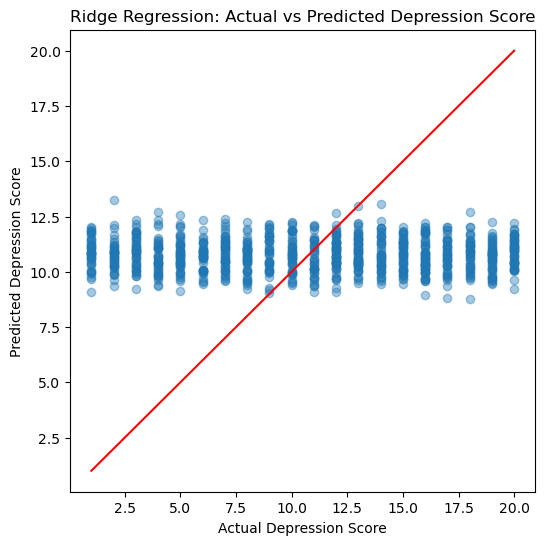

In [23]:
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

dep_X = df.drop(columns=target + exclude_cols)
dep_y = df["Depression_Score"]

y_pred_dep = cross_val_predict(
    ridge_depression.best_estimator_,
    dep_X,
    dep_y,
    cv=5)

plt.figure(figsize=(6, 6))
plt.scatter(dep_y, y_pred_dep, alpha=0.4)
plt.plot([dep_y.min(), dep_y.max()], 
         [dep_y.min(), dep_y.max()], 
         color="red")
plt.xlabel("Actual Depression Score")
plt.ylabel("Predicted Depression Score")
plt.title("Ridge Regression: Actual vs Predicted Depression Score")
plt.show()

The points are mostly scattered in a horizontal band and do not follow the diagonal line, which shows that the Ridge model predicts nearly the same depression score for most individuals regardless of their actual values. This pattern indicates that the model is not capturing a strong relationship between the predictors and depression scores.

---

## Results Summary ##

The penalized linear model showed relatively large prediction errors, with root mean squared errors around six points for both depression and anxiety. The model also produced slightly negative values for the R squared measure, which indicates that it did not explain more variation than simply predicting the average score. These results suggest that a linear relationship between the predictors and the mental health outcomes is weak in this dataset, even when applying a penalty to prevent overfitting.